<a href="https://www.kaggle.com/code/theongy/getting-started-maneuver-detection?scriptVersionId=120424735" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
"""Command line to load the data (valid only for this notebook)"""
import sys
package_paths = [
    '../input/hackathon2023/',
]

for pth in package_paths:
    sys.path.append(pth)
!cp -r '../input/maneuver-detection/' '/kaggle/working'

cp: cannot stat '../input/maneuver-detection/': No such file or directory


# Loading the dataset

A custom pytorch dataset is provided. It will parse the json dataset can be used with the pytorch loader. Since loading can sometimes take time, it is recommanded to execute the following cell at the beginning separately.

In [133]:
from ManeuverDetectionDataset import ManeuverDetectionDataset
dataset_path="TRAIN_1_IRREGULAR_STEPS_V2.json/TRAIN_1_IRREGULAR_STEPS_V2.json"
train_dataset= ManeuverDetectionDataset(dataset_path)



**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json/TRAIN_1_IRREGULAR_STEPS_V2.json
loading dataset. Ready in a minute!
TRAIN Dataset loaded. Size: 35762


As you can see, by default, the dataset is considered as a train dataset and 10% is not loaded for validation. To build the validation dataset, yo can do the same and you don't need to load again the json to save time ! **Beware : if you modify the code, you should take care to avoid to validate your model with the trained data!**

In [134]:
dataset= ManeuverDetectionDataset(dataset_path,dataset_type="VALIDATION",imported_dataset=train_dataset.dataset)



**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json/TRAIN_1_IRREGULAR_STEPS_V2.json
VALIDATION Dataset loaded. Size: 3974


In [135]:
validation_dataset= ManeuverDetectionDataset(dataset_path,dataset_type="VALIDATION",imported_dataset=train_dataset.dataset)



**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json/TRAIN_1_IRREGULAR_STEPS_V2.json
VALIDATION Dataset loaded. Size: 3974


Finally, you can create your pytorch loader and have fun with your networks !

In [136]:
from torch.utils.data import DataLoader

# 1550 batch = nb de sats observés
loader = DataLoader(train_dataset, batch_size=35762, drop_last=True)
feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(loader))
#print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")

In [137]:
feature.shape, is_maneuver.shape, maneuver_dv.shape, maneuver_time.shape

(torch.Size([35762, 1000, 3]),
 torch.Size([35762]),
 torch.Size([35762]),
 torch.Size([35762]))

In [94]:
input_feature = feature.numpy()
input_is_man = is_maneuver.numpy()
input_dv = maneuver_dv.numpy()
input_time = maneuver_time.numpy()

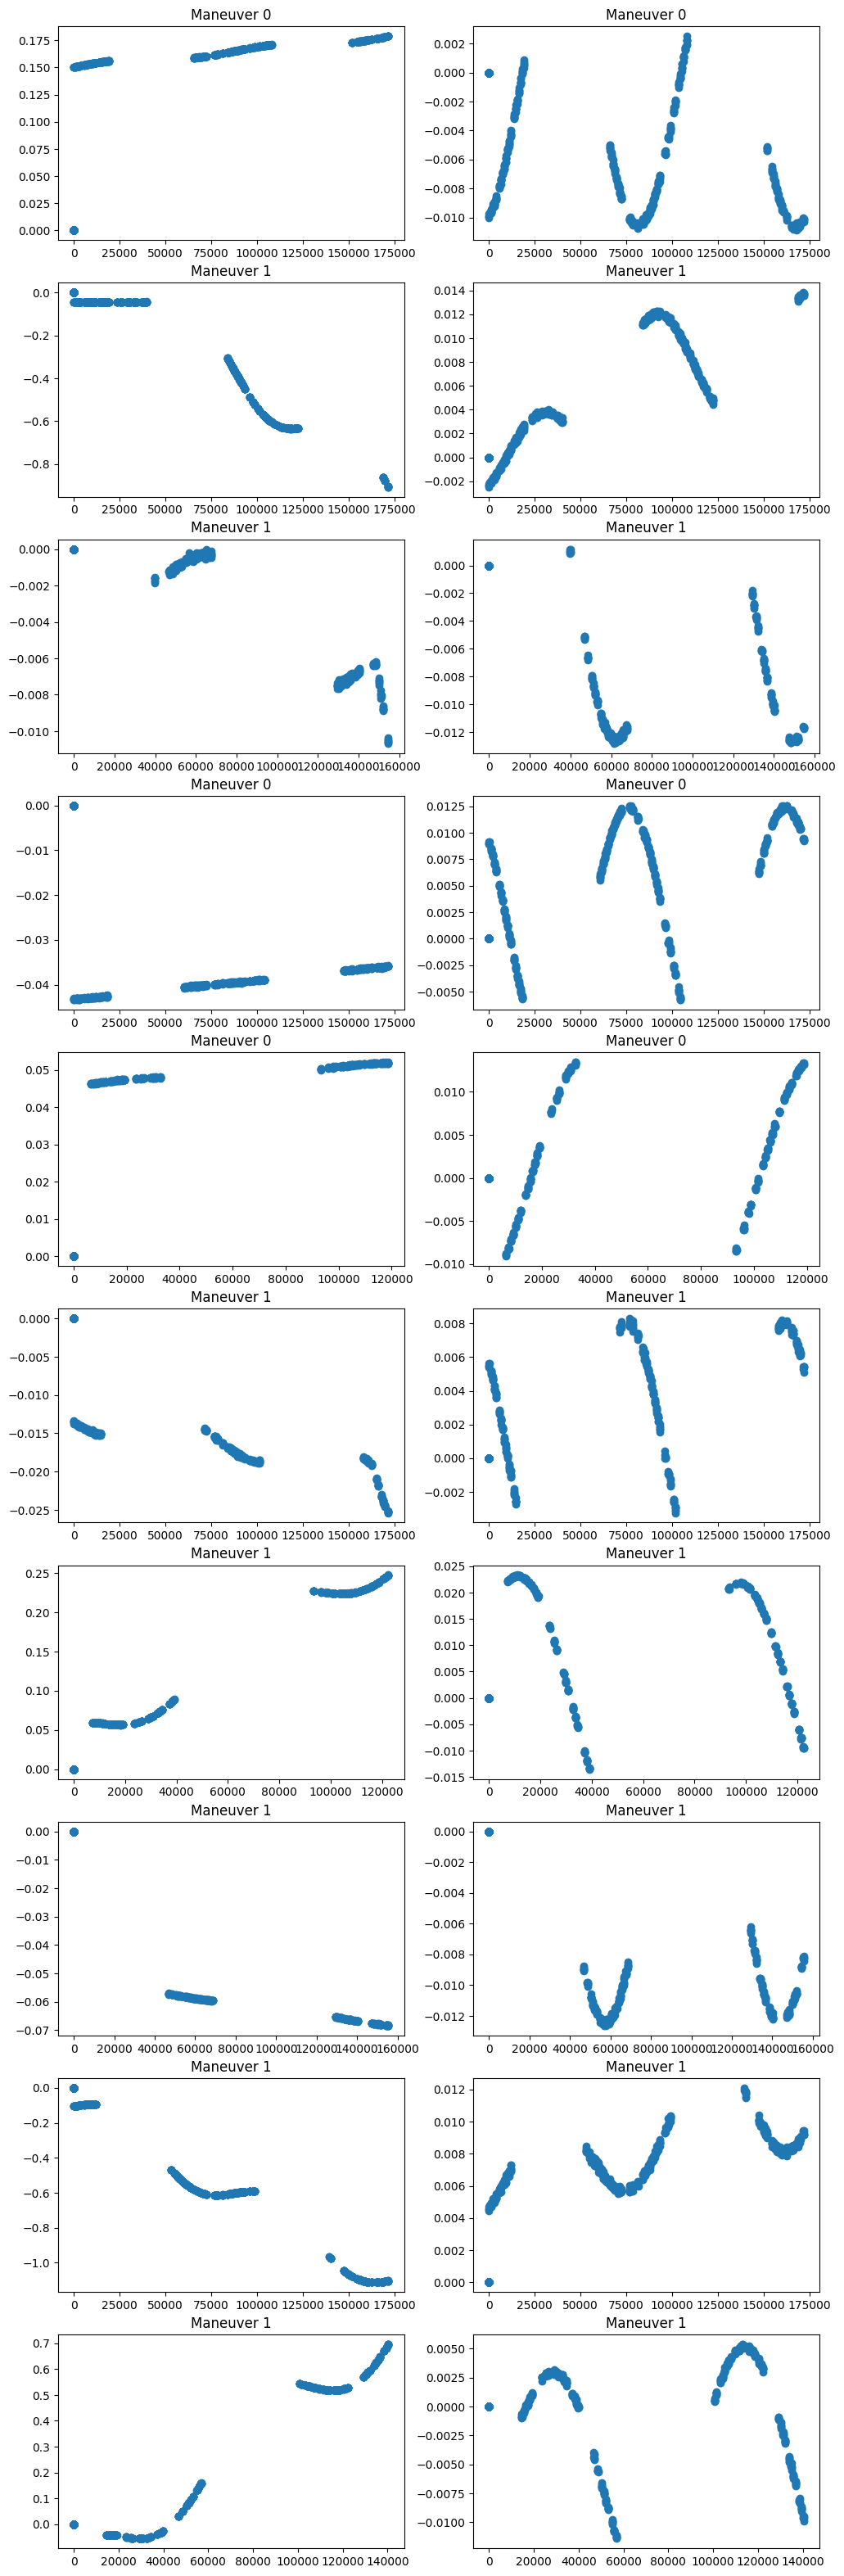

In [359]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(nrows=10, ncols=2, figsize=(12,40))
for i in range(10):
    ax[i][0].scatter(input_feature[i][:,2], input_feature[i][:,0])
    ax[i][0].set_title("Maneuver "+str(input_is_man[i]))
    ax[i][1].scatter(input_feature[i][:,2], input_feature[i][:,1])
    ax[i][1].set_title("Maneuver "+str(input_is_man[i]))

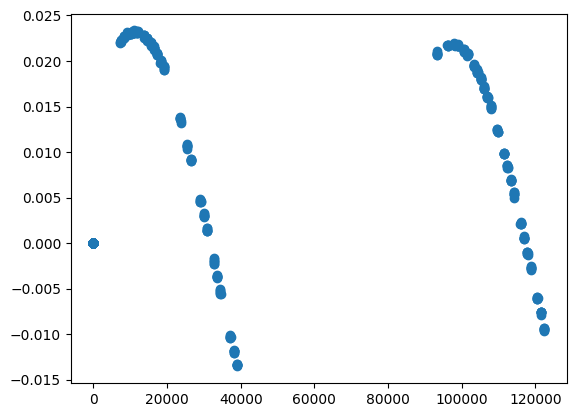

In [360]:
plt.scatter(input_feature[6][:,2], input_feature[6][:,1])

## Try with simple NN 

In [138]:
import torch
import torch.nn as nn

In [141]:
n_input, n_hidden1, n_hidden2, n_out, batch_size, learning_rate = 2000, 1000, 500, 1, 35762, 0.005

In [142]:
data_x = feature[:,:,:2]
data_y = is_maneuver.double()

In [143]:
print(data_x.size())
print(data_y.size())

torch.Size([35762, 1000, 2])
torch.Size([35762])


In [145]:
model = nn.Sequential(nn.Linear(n_input, n_hidden1),
                      nn.ReLU(),
                      nn.Linear(n_hidden1, n_hidden2),
                      nn.ReLU(),
                      nn.Linear(n_hidden2, n_out),
                      nn.Sigmoid())
model.double()
print(model)

Sequential(
  (0): Linear(in_features=2000, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=500, bias=True)
  (3): ReLU()
  (4): Linear(in_features=500, out_features=1, bias=True)
  (5): Sigmoid()
)


In [146]:
#loss_function = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [147]:
losses = []
for epoch in range(50):
    print("Epoch "+str(epoch))
    pred_y = model(data_x.reshape(-1, 2000))
    loss = loss_function(pred_y.reshape(batch_size), data_y)
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


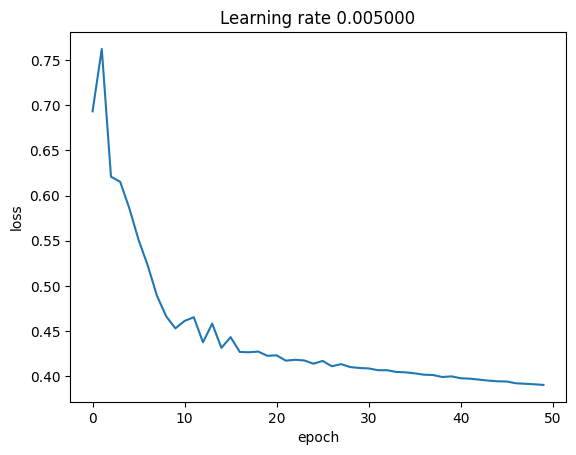

In [148]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [505]:
#Save the mpdel
PATH = './model_manoeuvre.pth'
torch.save(model.state_dict(), PATH)

In [149]:
valid_batch_size = 3974
loader2 = DataLoader(validation_dataset, batch_size=valid_batch_size, drop_last=True)
feature2,is_maneuver2,maneuver_dv2,maneuver_time2 =next(iter(loader2))

In [150]:
pred2 = model(feature2[:,:,:2].reshape(-1, 2000))

In [151]:
pred2.shape

torch.Size([3974, 1])

In [152]:
loss = loss_function(pred2.reshape(valid_batch_size ), is_maneuver2.double())
loss

tensor(0.4027, dtype=torch.float64, grad_fn=<BinaryCrossEntropyBackward0>)

In [153]:
TT, FT, TF, FF = 0, 0, 0, 0
NC = 0

pred_maneuver = []

for i in range(len(pred2)):
    #print(pred2[i].detach().numpy()[0] - is_maneuver2.numpy()[i])
    val = pred2[i].detach().numpy()[0] - is_maneuver2.numpy()[i]
    if (abs(val) < 0.5) & (is_maneuver2.numpy()[i] == 1):
        TT += 1
        pred_maneuver.append(1)
    elif (abs(val) < 0.5) & (is_maneuver2.numpy()[i] == 0):
        TF += 1
        pred_maneuver.append(0)
    elif (abs(val) > 0.5) & (is_maneuver2.numpy()[i] == 0):
        FT += 1
        pred_maneuver.append(1)
    elif (abs(val) > 0.5) & (is_maneuver2.numpy()[i] == 1):
        FF += 1
        pred_maneuver.append(0)
    else:
        NC += 1
        print(pred2[i].detach().numpy()[0])
print("")
print('TP', 'TN', 'FP', 'FN')
print(TT, TF, FT, FF)
print(NC)
print('Accuracy', (TT+TF)/valid_batch_size *100, '%')


TP TN FP FN
1287 1961 34 692
0
Accuracy 81.7312531454454 %


In [154]:
from sklearn.metrics import classification_report
import numpy as np

pred_maneuver = np.array(pred_maneuver)
real_maneuver = is_maneuver2.numpy()

print(classification_report(real_maneuver, pred_maneuver))

              precision    recall  f1-score   support

           0       0.74      0.98      0.84      1995
           1       0.97      0.65      0.78      1979

    accuracy                           0.82      3974
   macro avg       0.86      0.82      0.81      3974
weighted avg       0.86      0.82      0.81      3974



### Time prediction

In [171]:
from ManeuverDetectionDataset import ManeuverDetectionDataset
dataset_path="TRAIN_1_IRREGULAR_STEPS_V2.json/TRAIN_1_IRREGULAR_STEPS_V2.json"
train_dataset= ManeuverDetectionDataset(dataset_path, filter_samples="MANEUVER_ONLY")

validation_dataset= ManeuverDetectionDataset(dataset_path,dataset_type="VALIDATION",imported_dataset=train_dataset.dataset, filter_samples="MANEUVER_ONLY")

from torch.utils.data import DataLoader

loader = DataLoader(train_dataset, batch_size=17902, drop_last=True)
feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(loader))



**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? MANEUVER_ONLY
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json/TRAIN_1_IRREGULAR_STEPS_V2.json
loading dataset. Ready in a minute!
TRAIN Dataset loaded. Size: 17902


**********VALIDATION DATASET *********
Validation/Train ratio: 0.1
Samples filtered? MANEUVER_ONLY
Samples evenly spaced? False
path: TRAIN_1_IRREGULAR_STEPS_V2.json/TRAIN_1_IRREGULAR_STEPS_V2.json
VALIDATION Dataset loaded. Size: 1989


(array([1815., 1798., 1783., 1782., 1737., 1772., 1819., 1859., 1747.,
        1790.]),
 array([2.71502192e+00, 1.72816435e+04, 3.45605719e+04, 5.18395003e+04,
        6.91184288e+04, 8.63973572e+04, 1.03676286e+05, 1.20955214e+05,
        1.38234143e+05, 1.55513071e+05, 1.72791999e+05]),
 <BarContainer object of 10 artists>)

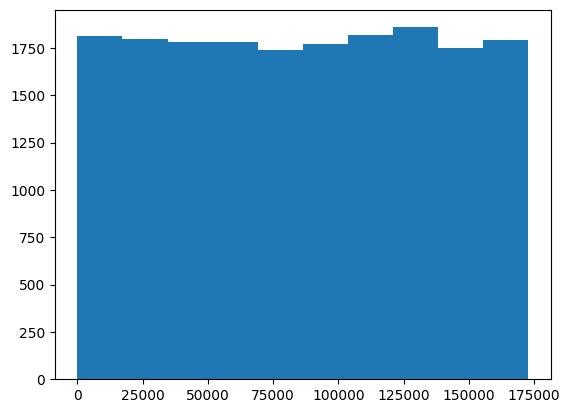

In [193]:
hist,bins = np.histogram(maneuver_time.numpy())
plt.hist(maneuver_time.numpy(), bins) 

In [172]:
maneuver_time_norm = (maneuver_time - maneuver_time.min())/(maneuver_time.max() - maneuver_time.min())
feature_norm = torch.clone(feature)
feature_norm[:,:,2] = (feature_norm[:,:,2] - feature[:,:,2].min())/(feature[:,:,2].max() - feature[:,:,2].min())

#### Interpolation

In [194]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline

x_train [-2.360e-03 -2.482e-03 -2.214e-03 -2.375e-03 -2.123e-03 -2.195e-03
 -2.120e-03 -2.050e-03 -1.974e-03 -1.965e-03 -2.142e-03 -2.193e-03
 -1.853e-03 -1.816e-03 -1.915e-03 -1.880e-03 -1.843e-03 -1.667e-03
 -1.836e-03 -1.668e-03 -1.763e-03 -1.881e-03 -1.750e-03 -1.805e-03
 -1.574e-03 -1.775e-03 -1.389e-03 -1.446e-03 -1.535e-03 -1.458e-03
 -1.571e-03 -1.285e-03 -1.586e-03 -9.939e-04 -9.616e-04 -1.039e-03
 -1.131e-03 -8.893e-04 -1.064e-03 -9.457e-04 -6.609e-04 -7.460e-04
 -7.768e-04 -7.691e-04 -1.012e-03 -7.006e-04 -6.621e-04 -5.423e-04
 -4.935e-04 -4.578e-04 -5.331e-04 -4.176e-04 -4.773e-04 -4.596e-04
 -4.821e-04 -2.911e-04 -4.255e-04 -2.974e-04 -2.367e-04 -4.718e-04
 -1.480e-04  1.484e-07 -2.897e-04 -2.744e-04  1.791e-04  2.306e-05
 -4.821e-06 -2.580e-05  3.077e-04  2.875e-04  1.253e-04  2.635e-04
  3.720e-04  3.113e-04  3.477e-04  3.679e-04  5.753e-04  2.116e-04
  3.184e-04  4.096e-04  4.687e-04  5.826e-04  7.254e-04  5.759e-04
  9.582e-04  6.136e-04  9.745e-04  7.669e-04  6.580e-0

NameError: name 'ax' is not defined

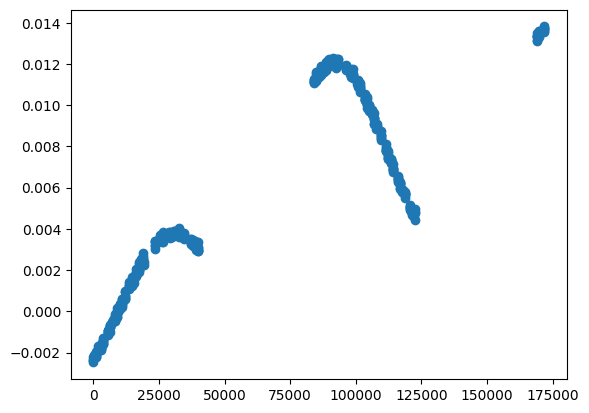

In [211]:
valid_ind = []
x_plot = np.linspace(0, 175000, 100)
X_plot = x_plot[:, np.newaxis]
for j in range(1):
    fig1 = plt.figure()
    for ind in range(1000):
        if torch.all(feature[j,ind,:] == torch.tensor([0,0,0])):
            valid_ind.append(ind)
            break
    plt.scatter(feature.numpy()[0][:488,2], feature.numpy()[0][:488,1])
    x_train = feature[j,:valid_ind[j],1].numpy()
    print("x_train", x_train)
    X_train = x_train[:, np.newaxis]
    for degree in [3, 4, 5]:
        model_poly = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=1e-3))
        model_poly.fit(X_train, feature[j,:valid_ind[j],1].numpy())
        y_plot = model_poly.predict(X_plot)
        ax.plot(x_plot, y_plot, label=f"degree {degree}")
    """
    model = make_pipeline(SplineTransformer(n_knots=4, degree=3), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)

    y_plot = model.predict(X_plot)
    ax.plot(x_plot, y_plot, label="B-spline")
    ax.legend(loc="lower center")
    ax.set_ylim(-20, 10)
    plt.show()    
    """

print(valid_ind)



In [173]:
n_input, n_hidden, n_out, batch_size, learning_rate = 3000, 500, 1, 17902, 0.005

In [174]:
data_x = feature
data_y = maneuver_time_norm.double()

In [175]:
model_time = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.ReLU())
model_time.double()
print(model_time)

Sequential(
  (0): Linear(in_features=3000, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=1, bias=True)
  (3): ReLU()
)


In [176]:
loss_function = nn.L1Loss()
optimizer = torch.optim.SGD(model_time.parameters(), lr=learning_rate)

In [177]:
losses = []
for epoch in range(200):
    print("Epoch "+str(epoch))
    pred_y = model_time(data_x.reshape(-1, 3000))
    loss = loss_function(pred_y.reshape(batch_size), data_y)
    losses.append(loss.item())

    model_time.zero_grad()
    loss.backward()

    optimizer.step()

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


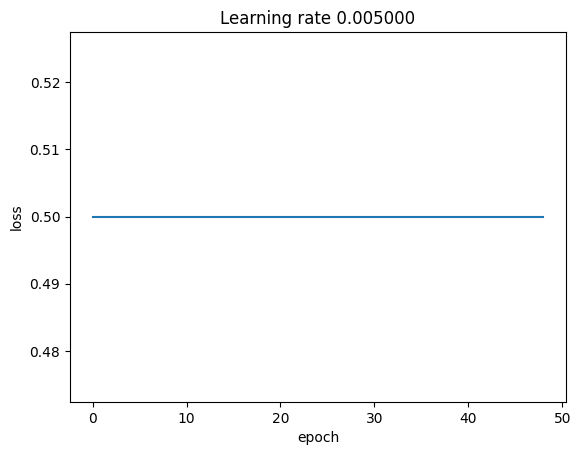

In [180]:
import matplotlib.pyplot as plt
plt.plot(losses[1:50])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [ ]:
#Save the mpdel
PATH = './model_temps.pth'
torch.save(model.state_dict(), PATH)

In [99]:
valid_batch_size = 1989
loader2 = DataLoader(validation_dataset, batch_size=valid_batch_size, drop_last=True)
feature2,is_maneuver2,maneuver_dv2,maneuver_time2 =next(iter(loader2))

In [100]:
maneuver_time2_norm = (maneuver_time2 - maneuver_time.min())/(maneuver_time.max() - maneuver_time.min())
feature2_norm = torch.clone(feature2)
feature2_norm[:,:,2] = (feature2_norm[:,:,2] - feature[:,:,2].min())/(feature[:,:,2].max() - feature[:,:,2].min())

In [109]:
maneuver_time2.max()

tensor(172788.9819, dtype=torch.float64)

In [101]:
feature[:,:,2].max()

tensor(172795.1640, dtype=torch.float64)

In [102]:
pred2 = model_time(feature2_norm.reshape(-1, 3000))

In [103]:
loss_function = nn.L1Loss()
#optimizer = torch.optim.SGD(model_time.parameters(), lr=learning_rate)

In [104]:
loss = loss_function(pred2.reshape(valid_batch_size), maneuver_time2_norm.double())
loss

tensor(0.2046, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [107]:
#Denormalisation
pred2_denorm = pred2*(maneuver_time.max() - maneuver_time.min()) + maneuver_time.min()
pred2_denorm

tensor([[77438.0453],
        [80788.2594],
        [47453.9088],
        ...,
        [89168.6953],
        [78606.3793],
        [76846.2323]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [115]:
pred2.max()

tensor(0.6720, dtype=torch.float64, grad_fn=<MaxBackward1>)

pred2_denorm.max(), maneuver_time2.max()

In [108]:
loss = loss_function(pred2_denorm.reshape(valid_batch_size), maneuver_time2.double())
loss

tensor(35357.8502, dtype=torch.float64, grad_fn=<MeanBackward0>)

--------------------------------------------------------------------------------

To load the test dataset, you should set the dataset type to TEST:

In [512]:
test_dataset_path="TEST_FILE_PUBLIC.json/TEST_FILE_PUBLIC.json"
test_dataset= ManeuverDetectionDataset(test_dataset_path,dataset_type="TEST")
test_loader = DataLoader(test_dataset, batch_size=1559, drop_last=True)
feature_test, is_maneuver_test ,maneuver_dv_test, maneuver_time_test =next(iter(test_loader))
#print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")




**********TEST DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? False
path: TEST_FILE_PUBLIC.json/TEST_FILE_PUBLIC.json
loading dataset. Ready in a minute!
TEST Dataset loaded. Size: 1559


In [513]:
len(test_dataset)

1559

In [515]:
feature_test.shape

torch.Size([1559, 1000, 3])

In [516]:
pred_test = model(feature_test[:,:,:2].reshape(-1, 2000))

In [518]:
pred_test.shape
pred_test

tensor([[1.0000],
        [1.0000],
        [0.4605],
        ...,
        [0.3944],
        [0.1585],
        [0.3125]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)

In [520]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [521]:
loss = loss_function(pred_test.reshape(1559), is_maneuver.double())
loss

ValueError: Using a target size (torch.Size([35762])) that is different to the input size (torch.Size([1559])) is deprecated. Please ensure they have the same size.

In [522]:
TT, FT, TF, FF = 0, 0, 0, 0
NC = 0

pred_maneuver = []

for i in range(len(pred_test)):
    val = pred_test[i].detach().numpy()[0] - is_maneuver.numpy()[i]
    if (abs(val) < 0.5) & (is_maneuver.numpy()[i] == 1):
        TT += 1
        pred_maneuver.append(1)
    elif (abs(val) < 0.5) & (is_maneuver.numpy()[i] == 0):
        TF += 1
        pred_maneuver.append(0)
    elif (abs(val) > 0.5) & (is_maneuver.numpy()[i] == 0):
        FT += 1
        pred_maneuver.append(1)
    elif (abs(val) > 0.5) & (is_maneuver.numpy()[i] == 1):
        FF += 1
        pred_maneuver.append(0)
    else:
        NC += 1
        print(pred_test[i].detach().numpy()[0])
print("")
print('TP', 'TN', 'FP', 'FN')
print(TT, TF, FT, FF)
print(NC)
print('Accuracy', (TT+TF)/valid_batch_size *100, '%')


TP TN FP FN
296 482 277 504
0
Accuracy 19.577252138902868 %


In [523]:
pred_maneuver

[1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,


for evenly spaced dataset, you should use the option fixed_step : 


In [ ]:
evenly_spaced_dataset_path="TRAIN_1_EVENLY_SPACED_V2.json/TRAIN_1_EVENLY_SPACED_V2.json"
evenly_spaced_dataset= ManeuverDetectionDataset(evenly_spaced_dataset_path,fixed_step=True)
evenly_spaced_loader = DataLoader(evenly_spaced_dataset, batch_size=1, drop_last=True)
feature,is_maneuver,maneuver_dv,maneuver_time =next(iter(evenly_spaced_loader))
print(f"features shape (batch size * nb of meas * nb of feature):{feature.shape}\nis maneuver: {is_maneuver.item()}\ndv (m/s): {maneuver_dv.item()}\nmaneuver date (seconds from the observation start): {maneuver_time.item()}")




**********TRAIN DATASET *********
Validation/Train ratio: 0.1
Samples filtered? NO
Samples evenly spaced? True
path: TRAIN_1_EVENLY_SPACED_V2.json/TRAIN_1_EVENLY_SPACED_V2.json
loading dataset. Ready in a minute!


#  It is time to submit !

When you think that your score is great you can submit ! To get started, you can generate your prediction file :

In [8]:
from SubmissionGenerator import create_submission
import numpy as np
#fake prediction
pred=np.zeros((len(test_dataset),3))
pred[:,0]=np.ones((len(test_dataset))) # classification
pred[:,1]=0.01*np.ones((len(test_dataset))) #dv
pred[:,2]=24*3600*np.ones((len(test_dataset))) #time of the maneuver
create_submission(pred,"/kaggle/working/prediction")


In [526]:
type(pred_maneuver)

list

In [529]:
from SubmissionGenerator import create_submission
import numpy as np
#fake prediction
pred=np.zeros((len(test_dataset),3))
pred[:,0]=np.array(pred_maneuver) # classification
pred[:,1]=0.01*np.ones((len(test_dataset))) #dv
pred[:,2]=24*3600*np.ones((len(test_dataset))) #time of the maneuver
create_submission(pred,"./prediction.csv")

Then, commit the file prediction.csv in the gitlab repository of your team. Don't forget to pull the repo before!
https://gitlab.com/TheoNguyen611/team-1-la-photomentalteam.git

https://gitlab.com/TheoNguyen611/team-2-avada-kedavra.git

https://gitlab.com/TheoNguyen611/team-3-frosty-gould.git

Wait a few moment and you should see your score appear in the leaderboard : http://34.163.85.74:5006/dashboard